# RNN with TensorFlow API

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

### The Data

In [2]:
class TimeSeriesData():
    
    def __init__(self,num_points,xmin,xmax):
        
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
    
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(self,batch_size,steps,return_batch_ts=False):
        
        # Grab a random starting point for each batch
        rand_start = np.random.rand(batch_size,1) 
        
        # Convert to be on time series
        ts_start = rand_start * (self.xmax- self.xmin - (steps*self.resolution) )
        
        # Create batch Time Series on t axis
        batch_ts = ts_start + np.arange(0.0,steps+1) * self.resolution
        
        # Create Y data for time series in the batches
        y_batch = np.sin(batch_ts)
        
        # Format for RNN
        if return_batch_ts:
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) , batch_ts
        
        else:
            
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 
        

In [3]:
ts_data = TimeSeriesData(250,0,10)

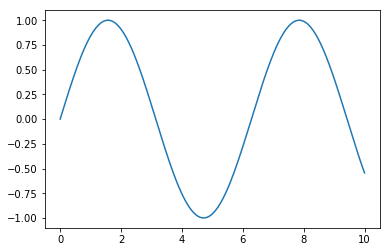

In [7]:
plt.plot(ts_data.x_data,ts_data.y_true)

In [8]:
# Num of steps in batch (also used for prediction steps into the future)
num_time_steps = 30

In [20]:
y1,y2,ts = ts_data.next_batch(1,num_time_steps,True)

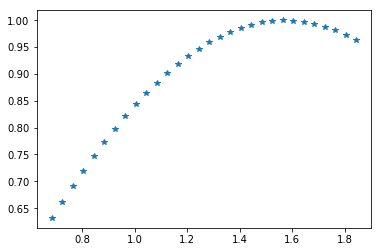

In [21]:
plt.plot(ts.flatten()[1:],y2.flatten(),'*')

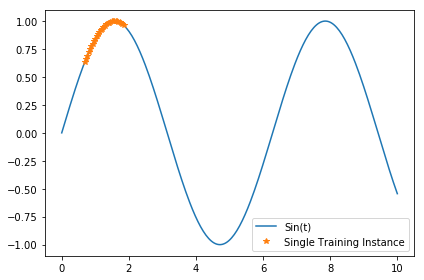

In [22]:
plt.plot(ts_data.x_data,ts_data.y_true,label='Sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*',label='Single Training Instance')
plt.legend()
plt.tight_layout()

### A Training Instance and what to predict

We are trying to predict a time series shifted over by t+1

In [23]:
train_inst = np.linspace(5, 5 + ts_data.resolution * (num_time_steps + 1), num_time_steps+1)

In [26]:
train_inst

array([ 5.        ,  5.04133333,  5.08266667,  5.124     ,  5.16533333,
        5.20666667,  5.248     ,  5.28933333,  5.33066667,  5.372     ,
        5.41333333,  5.45466667,  5.496     ,  5.53733333,  5.57866667,
        5.62      ,  5.66133333,  5.70266667,  5.744     ,  5.78533333,
        5.82666667,  5.868     ,  5.90933333,  5.95066667,  5.992     ,
        6.03333333,  6.07466667,  6.116     ,  6.15733333,  6.19866667,
        6.24      ])

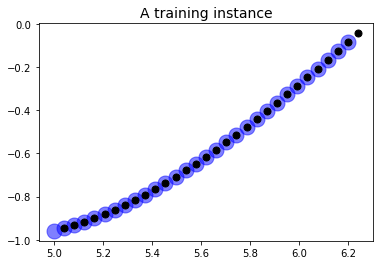

In [27]:
plt.title("A training instance", fontsize=14)
plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), "bo", markersize=15,alpha=0.5 ,label="instance")
plt.plot(train_inst[1:], ts_data.ret_true(train_inst[1:]), "ko", markersize=7, label="target")

___________

# Creating the Model

In [29]:
tf.reset_default_graph()

### Constants

In [32]:
# Just one feature, the time series
num_inputs = 1
# 100 neuron layer, play with this
num_neurons = 100
# Just one output, predicted time series
num_outputs = 1
# learning rate, 0.0001 default, but you can play with this
learning_rate = 0.0001
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 2000
# Size of the batch of data
batch_size = 1

### Placeholders

In [36]:
num_outputs

1

In [33]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

____
____
### RNN Cell Layer

Play around with the various cells in this section, compare how they perform against each other.

In [34]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs)

In [15]:
# cell = tf.contrib.rnn.OutputProjectionWrapper(
#     tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu),
#     output_size=num_outputs)

In [16]:
# n_neurons = 100
# n_layers = 3

# cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
#           for layer in range(n_layers)])

In [17]:
# cell = tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu)

In [18]:
# n_neurons = 100
# n_layers = 3

# cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
#           for layer in range(n_layers)])

_____
_____

### Dynamic RNN Cell

In [40]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

### Loss Function and Optimizer

In [41]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

#### Init Variables

In [42]:
init = tf.global_variables_initializer()

## Session

In [43]:
# ONLY FOR GPU USERS:
# https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)

In [44]:
saver = tf.train.Saver()

In [45]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./rnn_time_series_model")

0 	MSE: 0.610688
100 	MSE: 0.0510485
200 	MSE: 0.00592266
300 	MSE: 0.0306145
400 	MSE: 0.0141547
500 	MSE: 0.00328084
600 	MSE: 0.0112131
700 	MSE: 0.00172453
800 	MSE: 0.0129867
900 	MSE: 0.000414956
1000 	MSE: 0.000185533
1100 	MSE: 0.00689674
1200 	MSE: 0.00244606
1300 	MSE: 0.00314045
1400 	MSE: 0.00292688
1500 	MSE: 0.000131672
1600 	MSE: 0.00102012
1700 	MSE: 0.00143962
1800 	MSE: 0.0018517
1900 	MSE: 0.000443506


### Predicting a time series t+1

In [47]:
with tf.Session() as sess:                          
    saver.restore(sess, "./rnn_time_series_model")   

    X_new = np.sin(np.array(train_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


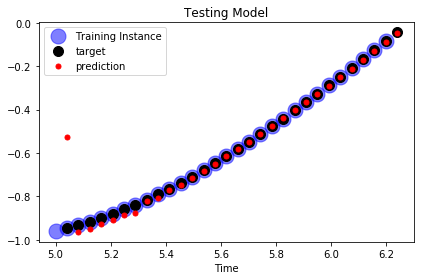

In [48]:
plt.title("Testing Model")

# Training Instance
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), "bo", markersize=15,alpha=0.5, label="Training Instance")

# Target to Predict
plt.plot(train_inst[1:], np.sin(train_inst[1:]), "ko", markersize=10, label="target")

# Models Prediction
plt.plot(train_inst[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")

plt.xlabel("Time")
plt.legend()
plt.tight_layout()

# Generating New Sequences
** Note: Can give wacky results sometimes, like exponential growth**

In [66]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_time_series_model")

    # SEED WITH ZEROS
    zero_seq_seed = [0. for i in range(num_time_steps)]
    for iteration in range(len(ts_data.x_data) - num_time_steps):
        X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        zero_seq_seed.append(y_pred[0, -1, 0])
        print(X_batch)
        print("\n")

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
[[[ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]]]


[[[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [-0.01492106]]]


[[[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        

[[[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [-0.01492106]
  [-0.02760385]
  [-0.04703645]
  [-0.07099212]
  [-0.10068931]
  [-0.13359651]
  [-0.16930889]
  [-0.20439491]
  [-0.23922116]
  [-0.27503392]
  [-0.31087586]
  [-0.34753659]
  [-0.38332435]
  [-0.41983876]
  [-0.45630568]
  [-0.49264404]
  [-0.52784163]
  [-0.56268781]
  [-0.59716517]
  [-0.63013309]
  [-0.66092807]]]


[[[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [-0.01492106]
  [-0.02760385]
  [-0.04703645]
  [-0.07099212]
  [-0.10068931]
  [-0.13359651]
  [-0.16930889]
  [-0.20439491]
  [-0.23922116]
  [-0.27503392]
  [-0.31087586]
  [-0.34753659]
  [-0.38332435]
  [-0.41983876]
  [-0.45630568]
  [-0.49264404]
  [-0.52784163]
  [-0.56268781]
  [-0.59716517]
  [-0.63013309]
  [-0.66092807]
  [-0.68968207]]]


[[[ 0.        ]
  [ 0.        ]


[[[-0.31087586]
  [-0.34753659]
  [-0.38332435]
  [-0.41983876]
  [-0.45630568]
  [-0.49264404]
  [-0.52784163]
  [-0.56268781]
  [-0.59716517]
  [-0.63013309]
  [-0.66092807]
  [-0.68968207]
  [-0.71686   ]
  [-0.74266267]
  [-0.76668233]
  [-0.78891987]
  [-0.80912632]
  [-0.82741714]
  [-0.84361935]
  [-0.85778958]
  [-0.86984509]
  [-0.87966275]
  [-0.88743228]
  [-0.89331704]
  [-0.89794815]
  [-0.9005779 ]
  [-0.90105712]
  [-0.89917374]
  [-0.895109  ]
  [-0.88892329]]]


[[[-0.34753659]
  [-0.38332435]
  [-0.41983876]
  [-0.45630568]
  [-0.49264404]
  [-0.52784163]
  [-0.56268781]
  [-0.59716517]
  [-0.63013309]
  [-0.66092807]
  [-0.68968207]
  [-0.71686   ]
  [-0.74266267]
  [-0.76668233]
  [-0.78891987]
  [-0.80912632]
  [-0.82741714]
  [-0.84361935]
  [-0.85778958]
  [-0.86984509]
  [-0.87966275]
  [-0.88743228]
  [-0.89331704]
  [-0.89794815]
  [-0.9005779 ]
  [-0.90105712]
  [-0.89917374]
  [-0.895109  ]
  [-0.88892329]
  [-0.88064224]]]


[[[-0.38332435]
  [-0.41983876]


[[[-0.86984509]
  [-0.87966275]
  [-0.88743228]
  [-0.89331704]
  [-0.89794815]
  [-0.9005779 ]
  [-0.90105712]
  [-0.89917374]
  [-0.895109  ]
  [-0.88892329]
  [-0.88064224]
  [-0.87029564]
  [-0.85787708]
  [-0.84332639]
  [-0.82670486]
  [-0.80814713]
  [-0.78766119]
  [-0.76527822]
  [-0.7409761 ]
  [-0.71468323]
  [-0.68650681]
  [-0.65648097]
  [-0.62474799]
  [-0.59134936]
  [-0.55633694]
  [-0.51984769]
  [-0.48238516]
  [-0.4451417 ]
  [-0.40788576]
  [-0.37051791]]]


[[[-0.87966275]
  [-0.88743228]
  [-0.89331704]
  [-0.89794815]
  [-0.9005779 ]
  [-0.90105712]
  [-0.89917374]
  [-0.895109  ]
  [-0.88892329]
  [-0.88064224]
  [-0.87029564]
  [-0.85787708]
  [-0.84332639]
  [-0.82670486]
  [-0.80814713]
  [-0.78766119]
  [-0.76527822]
  [-0.7409761 ]
  [-0.71468323]
  [-0.68650681]
  [-0.65648097]
  [-0.62474799]
  [-0.59134936]
  [-0.55633694]
  [-0.51984769]
  [-0.48238516]
  [-0.4451417 ]
  [-0.40788576]
  [-0.37051791]
  [-0.33323732]]]


[[[-0.88743228]
  [-0.89331704]


[[[-0.68650681]
  [-0.65648097]
  [-0.62474799]
  [-0.59134936]
  [-0.55633694]
  [-0.51984769]
  [-0.48238516]
  [-0.4451417 ]
  [-0.40788576]
  [-0.37051791]
  [-0.33323732]
  [-0.29629195]
  [-0.25968266]
  [-0.2233181 ]
  [-0.18729441]
  [-0.15086526]
  [-0.11492474]
  [-0.07701016]
  [-0.04125938]
  [-0.00678291]
  [ 0.02824523]
  [ 0.0654927 ]
  [ 0.10161887]
  [ 0.14101458]
  [ 0.18317516]
  [ 0.22375172]
  [ 0.26222956]
  [ 0.29922971]
  [ 0.33521494]
  [ 0.37249705]]]


[[[-0.65648097]
  [-0.62474799]
  [-0.59134936]
  [-0.55633694]
  [-0.51984769]
  [-0.48238516]
  [-0.4451417 ]
  [-0.40788576]
  [-0.37051791]
  [-0.33323732]
  [-0.29629195]
  [-0.25968266]
  [-0.2233181 ]
  [-0.18729441]
  [-0.15086526]
  [-0.11492474]
  [-0.07701016]
  [-0.04125938]
  [-0.00678291]
  [ 0.02824523]
  [ 0.0654927 ]
  [ 0.10161887]
  [ 0.14101458]
  [ 0.18317516]
  [ 0.22375172]
  [ 0.26222956]
  [ 0.29922971]
  [ 0.33521494]
  [ 0.37249705]
  [ 0.41164029]]]


[[[-0.62474799]
  [-0.59134936]


[[[ 0.02824523]
  [ 0.0654927 ]
  [ 0.10161887]
  [ 0.14101458]
  [ 0.18317516]
  [ 0.22375172]
  [ 0.26222956]
  [ 0.29922971]
  [ 0.33521494]
  [ 0.37249705]
  [ 0.41164029]
  [ 0.45288745]
  [ 0.49559554]
  [ 0.53625488]
  [ 0.57615334]
  [ 0.6145882 ]
  [ 0.65008938]
  [ 0.68330139]
  [ 0.71447945]
  [ 0.74341899]
  [ 0.76950949]
  [ 0.79351062]
  [ 0.81609303]
  [ 0.83707339]
  [ 0.85633057]
  [ 0.87440419]
  [ 0.89182365]
  [ 0.90758008]
  [ 0.92194843]
  [ 0.93486822]]]


[[[ 0.0654927 ]
  [ 0.10161887]
  [ 0.14101458]
  [ 0.18317516]
  [ 0.22375172]
  [ 0.26222956]
  [ 0.29922971]
  [ 0.33521494]
  [ 0.37249705]
  [ 0.41164029]
  [ 0.45288745]
  [ 0.49559554]
  [ 0.53625488]
  [ 0.57615334]
  [ 0.6145882 ]
  [ 0.65008938]
  [ 0.68330139]
  [ 0.71447945]
  [ 0.74341899]
  [ 0.76950949]
  [ 0.79351062]
  [ 0.81609303]
  [ 0.83707339]
  [ 0.85633057]
  [ 0.87440419]
  [ 0.89182365]
  [ 0.90758008]
  [ 0.92194843]
  [ 0.93486822]
  [ 0.94604391]]]


[[[ 0.10161887]
  [ 0.14101458]


  [ 0.88872123]]]


[[[ 0.74341899]
  [ 0.76950949]
  [ 0.79351062]
  [ 0.81609303]
  [ 0.83707339]
  [ 0.85633057]
  [ 0.87440419]
  [ 0.89182365]
  [ 0.90758008]
  [ 0.92194843]
  [ 0.93486822]
  [ 0.94604391]
  [ 0.95546556]
  [ 0.96320271]
  [ 0.96929187]
  [ 0.97386485]
  [ 0.97671491]
  [ 0.97783744]
  [ 0.97740841]
  [ 0.975429  ]
  [ 0.97187066]
  [ 0.96686524]
  [ 0.96046191]
  [ 0.95264161]
  [ 0.94318098]
  [ 0.93196064]
  [ 0.91913778]
  [ 0.90476954]
  [ 0.88872123]
  [ 0.87093854]]]


[[[ 0.76950949]
  [ 0.79351062]
  [ 0.81609303]
  [ 0.83707339]
  [ 0.85633057]
  [ 0.87440419]
  [ 0.89182365]
  [ 0.90758008]
  [ 0.92194843]
  [ 0.93486822]
  [ 0.94604391]
  [ 0.95546556]
  [ 0.96320271]
  [ 0.96929187]
  [ 0.97386485]
  [ 0.97671491]
  [ 0.97783744]
  [ 0.97740841]
  [ 0.975429  ]
  [ 0.97187066]
  [ 0.96686524]
  [ 0.96046191]
  [ 0.95264161]
  [ 0.94318098]
  [ 0.93196064]
  [ 0.91913778]
  [ 0.90476954]
  [ 0.88872123]
  [ 0.87093854]
  [ 0.85149407]]]


[[[ 0.793510

[[[ 0.72948897]
  [ 0.70034707]
  [ 0.66974163]
  [ 0.63773596]
  [ 0.60428363]
  [ 0.56858915]
  [ 0.53039807]
  [ 0.48999986]
  [ 0.44770262]
  [ 0.40390474]
  [ 0.35856125]
  [ 0.31194347]
  [ 0.26421556]
  [ 0.21477734]
  [ 0.16188005]
  [ 0.1064785 ]
  [ 0.05115287]
  [-0.00477066]
  [-0.05751768]
  [-0.10482769]
  [-0.14968099]
  [-0.19413351]
  [-0.23290774]
  [-0.26894659]
  [-0.30243117]
  [-0.33753434]
  [-0.37265262]
  [-0.40761447]
  [-0.4409993 ]
  [-0.47178566]]]


[[[ 0.70034707]
  [ 0.66974163]
  [ 0.63773596]
  [ 0.60428363]
  [ 0.56858915]
  [ 0.53039807]
  [ 0.48999986]
  [ 0.44770262]
  [ 0.40390474]
  [ 0.35856125]
  [ 0.31194347]
  [ 0.26421556]
  [ 0.21477734]
  [ 0.16188005]
  [ 0.1064785 ]
  [ 0.05115287]
  [-0.00477066]
  [-0.05751768]
  [-0.10482769]
  [-0.14968099]
  [-0.19413351]
  [-0.23290774]
  [-0.26894659]
  [-0.30243117]
  [-0.33753434]
  [-0.37265262]
  [-0.40761447]
  [-0.4409993 ]
  [-0.47178566]
  [-0.50068748]]]


[[[ 0.66974163]
  [ 0.63773596]


[[[-0.14968099]
  [-0.19413351]
  [-0.23290774]
  [-0.26894659]
  [-0.30243117]
  [-0.33753434]
  [-0.37265262]
  [-0.40761447]
  [-0.4409993 ]
  [-0.47178566]
  [-0.50068748]
  [-0.52887201]
  [-0.55710566]
  [-0.58392125]
  [-0.60859084]
  [-0.63086593]
  [-0.65122348]
  [-0.66975695]
  [-0.68627888]
  [-0.7005924 ]
  [-0.71281374]
  [-0.7226873 ]
  [-0.73023868]
  [-0.73532104]
  [-0.73797029]
  [-0.73804712]
  [-0.73556238]
  [-0.73061794]
  [-0.72328693]
  [-0.71385801]]]


[[[-0.19413351]
  [-0.23290774]
  [-0.26894659]
  [-0.30243117]
  [-0.33753434]
  [-0.37265262]
  [-0.40761447]
  [-0.4409993 ]
  [-0.47178566]
  [-0.50068748]
  [-0.52887201]
  [-0.55710566]
  [-0.58392125]
  [-0.60859084]
  [-0.63086593]
  [-0.65122348]
  [-0.66975695]
  [-0.68627888]
  [-0.7005924 ]
  [-0.71281374]
  [-0.7226873 ]
  [-0.73023868]
  [-0.73532104]
  [-0.73797029]
  [-0.73804712]
  [-0.73556238]
  [-0.73061794]
  [-0.72328693]
  [-0.71385801]
  [-0.70182455]]]


[[[-0.23290774]
  [-0.26894659]


[[[-0.71281374]
  [-0.7226873 ]
  [-0.73023868]
  [-0.73532104]
  [-0.73797029]
  [-0.73804712]
  [-0.73556238]
  [-0.73061794]
  [-0.72328693]
  [-0.71385801]
  [-0.70182455]
  [-0.68703687]
  [-0.6693576 ]
  [-0.6491493 ]
  [-0.62663627]
  [-0.60186189]
  [-0.57481635]
  [-0.54530793]
  [-0.51347059]
  [-0.47937876]
  [-0.44340441]
  [-0.40729827]
  [-0.37108645]
  [-0.3347041 ]
  [-0.2980279 ]
  [-0.26160207]
  [-0.2250537 ]
  [-0.18853165]
  [-0.15150209]
  [-0.11539085]]]


[[[-0.7226873 ]
  [-0.73023868]
  [-0.73532104]
  [-0.73797029]
  [-0.73804712]
  [-0.73556238]
  [-0.73061794]
  [-0.72328693]
  [-0.71385801]
  [-0.70182455]
  [-0.68703687]
  [-0.6693576 ]
  [-0.6491493 ]
  [-0.62663627]
  [-0.60186189]
  [-0.57481635]
  [-0.54530793]
  [-0.51347059]
  [-0.47937876]
  [-0.44340441]
  [-0.40729827]
  [-0.37108645]
  [-0.3347041 ]
  [-0.2980279 ]
  [-0.26160207]
  [-0.2250537 ]
  [-0.18853165]
  [-0.15150209]
  [-0.11539085]
  [-0.07751168]]]


[[[-0.73023868]
  [-0.73532104]




[[[-0.47937876]
  [-0.44340441]
  [-0.40729827]
  [-0.37108645]
  [-0.3347041 ]
  [-0.2980279 ]
  [-0.26160207]
  [-0.2250537 ]
  [-0.18853165]
  [-0.15150209]
  [-0.11539085]
  [-0.07751168]
  [-0.04169367]
  [-0.00716378]
  [ 0.02778105]
  [ 0.06499095]
  [ 0.10095263]
  [ 0.14004254]
  [ 0.18195675]
  [ 0.22228041]
  [ 0.26047772]
  [ 0.29716045]
  [ 0.3328357 ]
  [ 0.36980331]
  [ 0.40859926]
  [ 0.44967929]
  [ 0.4924159 ]
  [ 0.53318006]
  [ 0.57301551]
  [ 0.61157143]]]


[[[-0.44340441]
  [-0.40729827]
  [-0.37108645]
  [-0.3347041 ]
  [-0.2980279 ]
  [-0.26160207]
  [-0.2250537 ]
  [-0.18853165]
  [-0.15150209]
  [-0.11539085]
  [-0.07751168]
  [-0.04169367]
  [-0.00716378]
  [ 0.02778105]
  [ 0.06499095]
  [ 0.10095263]
  [ 0.14004254]
  [ 0.18195675]
  [ 0.22228041]
  [ 0.26047772]
  [ 0.29716045]
  [ 0.3328357 ]
  [ 0.36980331]
  [ 0.40859926]
  [ 0.44967929]
  [ 0.4924159 ]
  [ 0.53318006]
  [ 0.57301551]
  [ 0.61157143]
  [ 0.64731109]]]


[[[-0.40729827]
  [-0.37108645

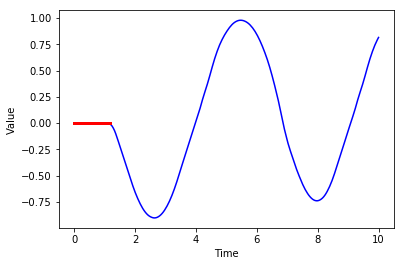

In [67]:
plt.plot(ts_data.x_data, zero_seq_seed, "b-")
plt.plot(ts_data.x_data[:num_time_steps], zero_seq_seed[:num_time_steps], "r", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

In [68]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_time_series_model")

    # SEED WITH Training Instance
    training_instance = list(ts_data.y_true[:30])
    for iteration in range(len(training_instance) -num_time_steps):
        X_batch = np.array(training_instance[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        training_instance.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


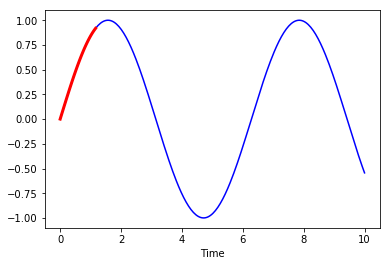

In [69]:
plt.plot(ts_data.x_data, ts_data.y_true, "b-")
plt.plot(ts_data.x_data[:num_time_steps],training_instance[:num_time_steps], "r-", linewidth=3)
plt.xlabel("Time")

# Great Job!